# CS F415 Data Mining - Home Loan Approval

### Problem Statement & Data Set
Suppose a Finance Company offers home loans across urban, semi-urban,
and rural areas. The loan approval process typically spans 1 week to 1 month
due to extensive customer research.To streamline this, we'll employ Data
Mining techniques to automate and expedite loan approvals.

### About the dataset
The loan application data set includes various columns that provide
information on the applicant and the loan, such as Loan ID, Gender, Marital
Status,Dependents, Education, Self-Employment status, Applicant Income,
Co-Applicant Income, Loan Amount, Loan Amount Term, Credit History, and
Property Area.

## Data Preprocessing
### 1. Importing Dependencies and Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

/var/folders/2s/v783hrsx7ld3cdp_cm9ghqd80000gn/T/ipykernel_20526/199805642.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Data
We have two csv files: train & test.

Train file contains all independent variables and target variables which'll be used to train the model. (i.e. train csv has loan_status column, but test csv doesn't)

Test file has independent variables, but not the target variables. This model will predict test variables for the test data.

In [2]:
train=pd.read_csv('./datasets/loan_sanction_train.csv')
test=pd.read_csv('./datasets/loan_sanction_test.csv')

In [3]:
print(train.shape)
train.head(10)

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.0,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.0,360.0,1.0,Semiurban,N


#### Checking for duplicates and missing values

In [4]:
print(f"No. of duplicates: {train.duplicated().sum()}")
train.isnull().sum()

No. of duplicates: 0


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

* We have no duplicates, but have several missing values

In [5]:
train.select_dtypes('object').nunique()

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64


* Since the value of Loan_Id is unique for each row, we can remove Loan_ID as it won't be useful in model training.

In [6]:
train.drop(columns=['Loan_ID'],inplace=True)

In [7]:
train.describe(include="number") # describing numerical data

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [8]:
desc = train.describe(exclude="number") # describing categorical data

for col in desc.columns:
    top_category = desc.loc['top', col]
    percentage = ((train[col] == top_category).mean()*100).round(2)
    desc.loc['top_percentage', col] = percentage

desc

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,601,611,599,614,582,614,614
unique,2,2,4,2,2,3,2
top,Male,Yes,0,Graduate,No,Semiurban,Y
freq,489,398,345,480,500,233,422
top_percentage,79.64,64.82,56.19,78.18,81.43,37.95,68.73


* There are more Male(79.64%) applicants than Female.
* Frequency of Married(64.82%) applicants is more.
* There are more Graduate(78.18%) applicants.

#### Data Visualization

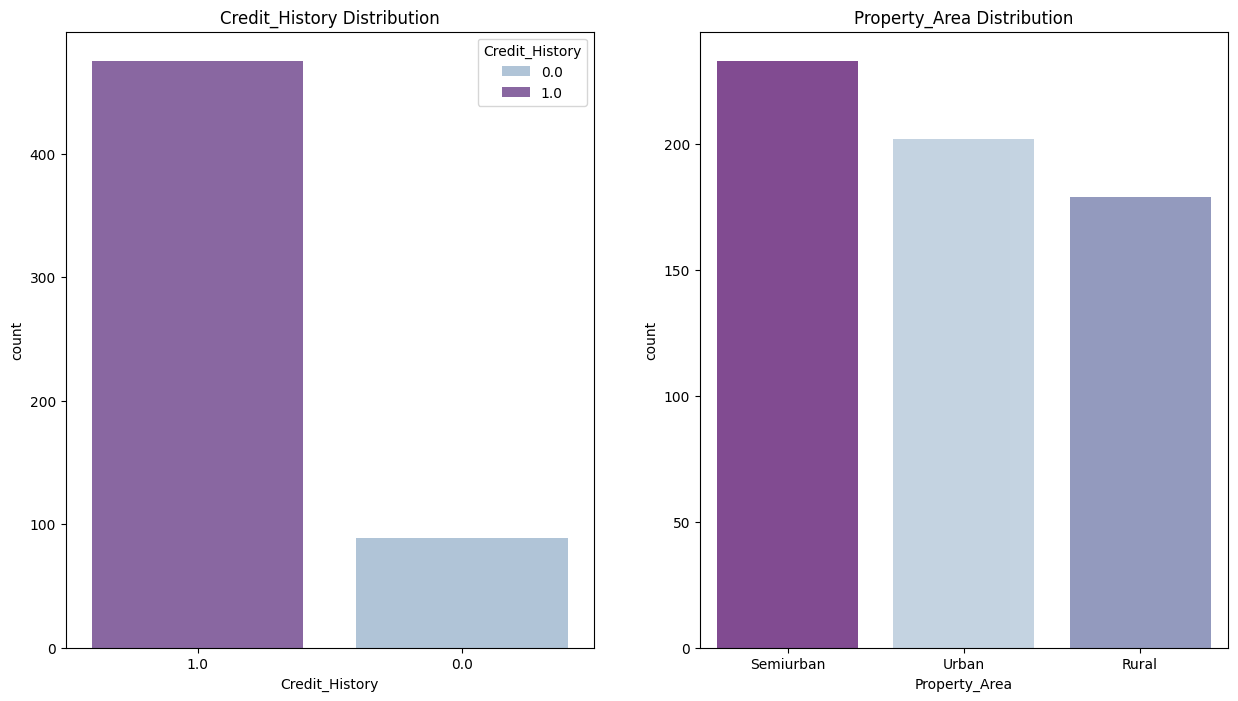

In [9]:
df=train[['Credit_History','Property_Area']]
fig,ax=plt.subplots(1,2,figsize=(15,8))

for i,feature in enumerate(df):
    order=(
        df[feature]
        .value_counts(normalize=True)
        .sort_values(ascending=False).index
    )

    sns.countplot(x=feature, data=df, order=order, ax=ax[i], palette='BuPu',hue=feature)
    ax[i].set_title(f'{feature} Distribution')

##### Checking for outliers

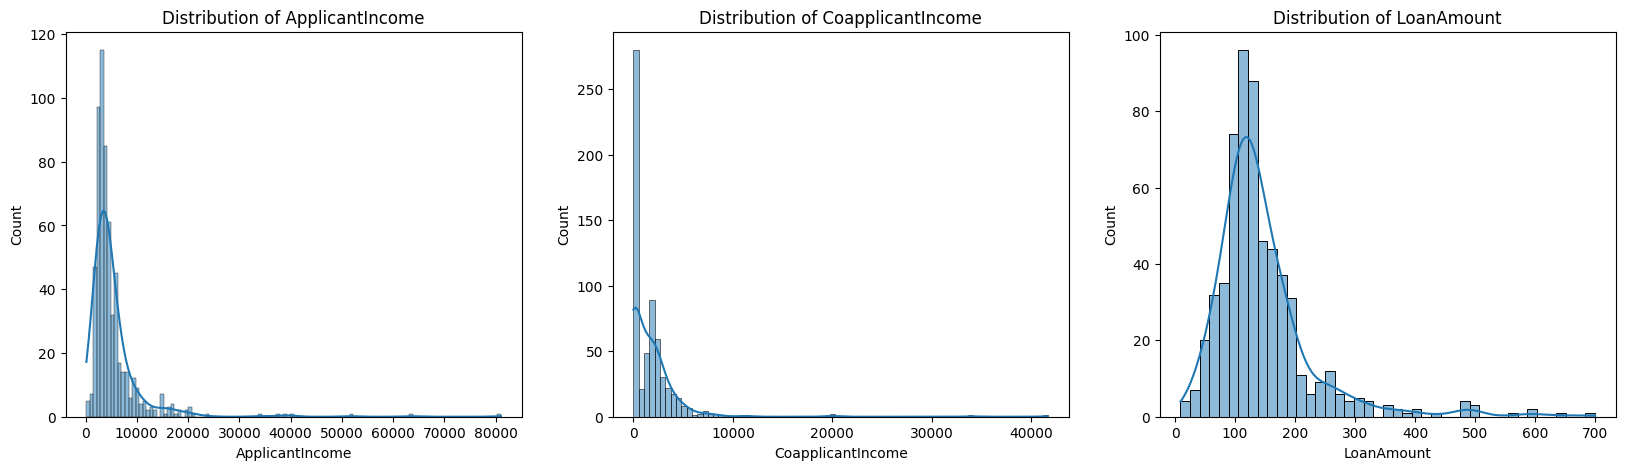

In [15]:
df = train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']]

fig,ax = plt.subplots(1,3,figsize=(20,5))

for i,features in enumerate(df):
    sns.histplot(data=train,x=features,ax=ax[i],kde=True)
    ax[i].set_title(f'Distribution of {features}')

* Applicant Income & Coapplicant Income have extreme outliers

##### Dropping Attributes based on Correlation Matrix

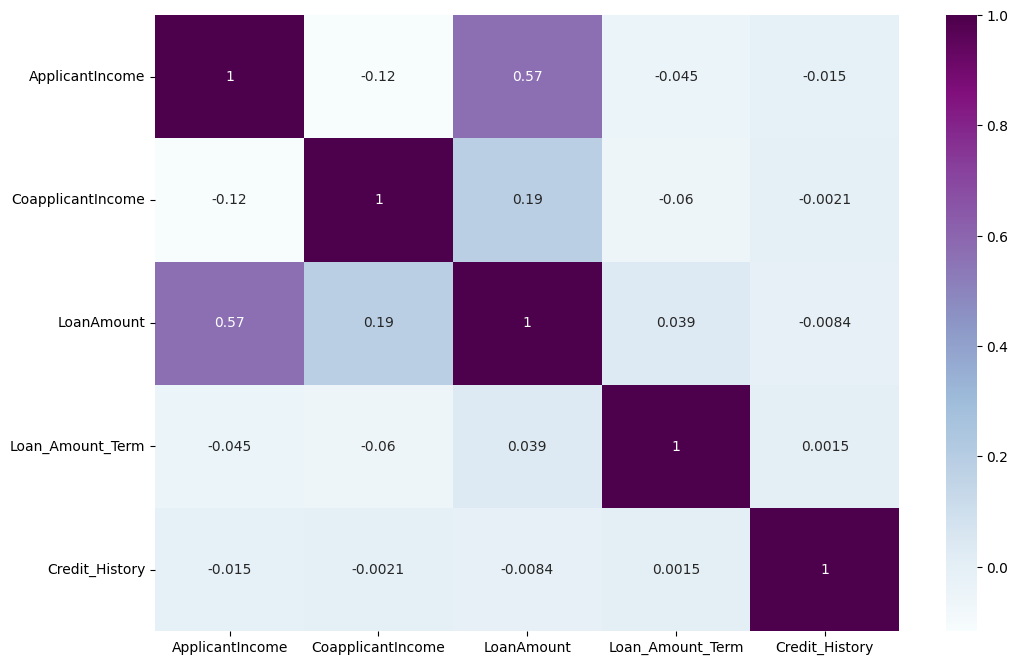

In [11]:
fig_dims=(12,8)
fig,ax=plt.subplots(figsize=fig_dims)

num_features=train.select_dtypes(include='number')
sns.heatmap(num_features.corr(),annot=True,ax=ax, cmap='BuPu')
plt.show()